In [1]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!git clone https://github.com/parth1620/object-localization-dataset.git
!pip install timm

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-i6apy4si
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-i6apy4si
  Resolved https://github.com/albumentations-team/albumentations to commit 2dd16a5d598a4c9bd36986d51a5c91a4c2607a08
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 31.5 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.3-py3-none-any.whl size=137347 sha256=c2f1bfb3153a308b6c00e5487ffba75d191253d8c09570739fbe9e1696f19ed5
  Stored in directory: /tmp/pip-ephem-wheel-cache-nf1y0qg5/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: scik

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd
!ls drive/MyDrive/Colab_Notebooks/analytics-fundamentals-ii-2022-2-convnets

/content
 images			 test.csv		    train.csv		        train.gsheet
 sample_submission.csv	'test(EGGPLANT_ONLY).csv'  'train(EGGPLANT_ONLY).csv'


In [4]:
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.models import resnet50, ResNet50_Weights
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from tqdm.notebook import tqdm
import timm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import albumentations as A
import cv2
import sys
sys.path.append('/content/object-localization-dataset')
import utils
#from ultralytics import YOLO
#from roboflow import Roboflow #needed for using the ultralytics trained model
#from functions import loadDataSet


In [5]:
CSV_FILE_TRAIN = "./drive/MyDrive/Colab_Notebooks/analytics-fundamentals-ii-2022-2-convnets/train.csv"
CSV_FILE_TEST = "./drive/MyDrive/Colab_Notebooks/analytics-fundamentals-ii-2022-2-convnets/test.csv"
IMAGE_DIR = "./drive/MyDrive/Colab_Notebooks/analytics-fundamentals-ii-2022-2-convnets/images"
EGGPLANT_CSV_FILE_TRAIN = "./drive/MyDrive/Colab_Notebooks/analytics-fundamentals-ii-2022-2-convnets/train(EGGPLANT_ONLY).csv"
EGGPLANT_CSV_FILE_TEST = "./drive/MyDrive/Colab_Notebooks/analytics-fundamentals-ii-2022-2-convnets/test(EGGPLANT_ONLY).csv"

BATCH_SIZE = 3
IMAGE_SIZE = 180
LEARNING_RATE = 0.01
EPOCHS = 40
MODEL_NAME = "resnet50"

NUMBER_OF_COORDINATES = 4
dfTrain = pd.read_csv(EGGPLANT_CSV_FILE_TRAIN)
dfTest = pd.read_csv(EGGPLANT_CSV_FILE_TEST)
dfTrain


,filename,classname,xmin,ymin,xmax,ymax
0,img_164.jpg,eggplant,56,85,171,182
1,img_101.jpg,eggplant,19,42,213,186
2,img_185.jpg,eggplant,5,12,190,209
3,img_76.jpg,eggplant,36,72,205,187
4,img_116.jpg,eggplant,62,76,171,191
5,img_102.jpg,eggplant,32,41,192,198
6,img_162.jpg,eggplant,64,48,166,148
7,img_155.jpg,eggplant,29,36,171,198
8,img_36.jpg,eggplant,67,22,177,215
9,img_56.jpg,eggplant,56,29,182,220


[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


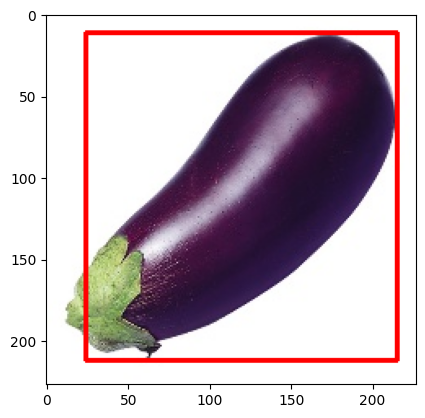

In [6]:
row = dfTrain.iloc[17] #get row 17 from the train dataset
img = cv2.imread(IMAGE_DIR + "/" + row.filename)#read the image in row index 17
print(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#convert image from BGR color space to RGB color space
upLeftPoint = (row.xmin, row.ymin) #upper left point of the bounding box coordinates
lowRightPoint = (row.xmax, row.ymax) #lower right point of the bounding box coordinates
bounding_box_img = cv2.rectangle(img, upLeftPoint, lowRightPoint, (255, 0, 0), 2)#cv2.rectangle creates bounding box with coordinates upLeftPoint, lowRightPoint and gives it the color (255, 0, 0) which is red and line size of bounding box is 2
plt.imshow(bounding_box_img)#plot the image with bounding box included

In [7]:
train_df, valid_df = train_test_split(dfTrain, test_size=0.20, random_state=42)

In [8]:
#data augmentation for the training dataset
train_aug = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),#Resize all the images
    A.HorizontalFlip(p=0.5),#horizontal flip with a probability of horizontally flipping being 0.5
    A.VerticalFlip(p=0.5),#Vertical flip with a probability of vertically flipping being 0.5
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))#since this is an object localization task we need to mention bounding box parameters A.BboxParams() and we also have to specify the label_field

#data augmentation for the validation dataset
#we just use Resize for validation augmentation because validation won't do any other augmentation
valid_aug = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),#Resize all the images
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))#since this is an object localization task we need to mention bounding box parameters A.BboxParams() and we also have to specify the label_field

In [9]:
class ObjLocDataset(torch.utils.data.Dataset):
  def __init__(self, df, augmentations=None):#By default the augmentations are going to be None
    self.df = df
    self.augmentations = augmentations

  def __len__(self): #This method is going to return the length of the dataset
    return len(self.df)

  def __getitem__(self, idx):#returns the image and bounding box coordinates (Note: idx is short for index)
    row = self.df.iloc[idx]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax
    bbox = [[xmin, ymin, xmax, ymax]]#This nested list will hold all the bounding box coordinates of box at index idx and we need it in this format because albumentation takes bounding box coordinates in this format
    img_path = IMAGE_DIR + "/" + row.filename
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if self.augmentations:#if self.augmentations is true give us the augmented data into a dictionary format
      data = self.augmentations(image = img, bboxes=bbox, class_labels=[None])#since we're not doing a classification task we give class_lables a None list
      img = data['image']#extract image and bounding box coordinates according to key since we're getting the augmented data in dictionary format
      bbox = data['bboxes'][0]#since its a nested list we mention the index of the list within the bbox list we want

    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0#convert our image into numpy convention and pytorch uses height, width convention so shift our channel to the zero axis and scale our image by dividing it by 255.0
    #Note: permute is in format of (height, width, channel) and means we want the 2nd axis (2) on the zeroth axis (0) the channel will come on the zeroth axis so its going to be (channel, height, width)
    #So permutation convert (height, width, channel) in this case to (channel, height width)
    #we convert the img this way because pytorch uses (channel, height, width) convention so the model should take the image stencil in the format of (channel, height, width)
    bbox = torch.Tensor(bbox)#we also want to convert the bbox to convention usable in pytorch
    return img, bbox

In [10]:
trainset = ObjLocDataset(dfTrain, train_aug)#create training set with data augmentations
validset = ObjLocDataset(dfTrain, valid_aug)#create validation set with data augmentations

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)#lets not shuffle the batches for our validation loader

print("Total no. batches in trainloader : {}".format(len(trainloader)))#print total # of batches in trainloader
print("Total no. batches in validloader : {}".format(len(validloader)))#print total # of batches in validloader

for images, bboxes in trainloader:#Lets now load one batch
  break;#Now we just want to load the first batch to see the shape of the images and bounding boxes so we break the loop here


print("Shape of one batch images : {}".format(images.shape))#one batch of images has 16, 3, 140, 140 (16 is batch size, 3 is # of channels, 140 height, and 140 width)
print("Shape of one batch bboxes : {}".format(bboxes.shape))#each box has 16, 4 (16 is batch size, 4 is the # of values) the 4 values are xmin, ymin, xmax, and ymax
#one batch has 16, 3, 140, 140 (16 is batch size, 3 is # of channels, 140 height, and 140 width)

Total no. batches in trainloader : 14
Total no. batches in validloader : 14
Shape of one batch images : torch.Size([3, 3, 180, 180])
Shape of one batch bboxes : torch.Size([3, 4])


In [11]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()
    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)#pretrained=True to initialize the pre-trained weights, num_class is the output nodes and we want that to be 4 which are the values of xmin, ymin, xmax, and ymax

  def forward(self, images, true_bboxes=None):#true_bboxes are the true value bounding boxes
    pred_bboxes = self.backbone(images, ) #pass the images inside the backbone/model
    if true_bboxes != None:#if true_bboxes != None return the loss and logits
      loss = nn.MSELoss()(pred_bboxes, true_bboxes)#use Mean squared error
      return pred_bboxes, loss
    return pred_bboxes

model = ObjLocModel()
print(model)
random_img = torch.rand(1, 3, 140, 140)#img of shape 1, 3, 140, 140 (1 is batch size, 3 is # of channels, 140 is the height, (4th parameter) 140 is the width)
model(random_img).shape#displays the shape of the random_img's bounding box as output after passing it through the model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

ObjLocModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05,

torch.Size([1, 4])

In [12]:
def train(model, dataloader, optimizer):
  total_loss = 0.0
  model.train()
  for data in tqdm(dataloader):
    images, true_bboxes = data
    pred_bboxes, loss = model(images, true_bboxes)
    optimizer.zero_grad()
    loss.backward()#find the gradients (step 2 of gradient descent computation)
    optimizer.step()
    total_loss += loss.item()
  return total_loss / len(dataloader)

In [13]:
def eval(model, dataloader):
  total_loss = 0.0
  model.eval()#specifies that the model should be in eval mode which turns the dropout layer off
  with torch.no_grad():#we can also add this line to be sure that there's no gradient computation inside the eval function
    for data in tqdm(dataloader):
      images, true_bboxes = data
      pred_bboxes, loss = model(images, true_bboxes)#pass our images and true bounding boxes to the model to get predicted bounding boxes and the loss
      total_loss += loss.item()#Sum up all of the losses (every batch loss will be in the total loss)
    return total_loss / len(dataloader)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)#declare the optimizer and the optimizer we're going to use is the Adam optimizer and pass in the models parameters which are the weights and the biases we also pass in the learning rate lr

In [17]:
best_valid_loss = np.Infinity
best_train_loss = np.Infinity

#this is where we start the training and the training loop
for i in range(EPOCHS):
  train_loss = train(model, trainloader, optimizer)
  valid_loss = eval(model, validloader)
  if valid_loss < best_valid_loss:#if valid_loss < best_valid_loss we save the model and save it as best_model.pt
    torch.save(model.state_dict(), "best_model.pt")#save the model and it's weights and save it as best_model.pt
    print("WEIGHTS ARE SAVED")
    best_valid_loss = valid_loss #update the best_valid_loss as valid_loss
  print(f"Epoch: {i + 1} train loss: {train_loss} valid loss: {valid_loss}")#print train and valid loss
  #The first progress bar is for the train function
  #The second progress bar is for the eval function

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 1 train loss: 329.3817547389439 valid loss: 256.59319850376676


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 2 train loss: 297.9190058026995 valid loss: 312.4243049621582


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 3 train loss: 324.4812218802316 valid loss: 223.854496547154


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 4 train loss: 276.9990599496024 valid loss: 288.54311970302035


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 5 train loss: 340.85598645891463 valid loss: 229.64713178362166


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 6 train loss: 335.0856034415109 valid loss: 240.29081453595842


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 7 train loss: 292.5629130772182 valid loss: 227.2612075805664


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 8 train loss: 259.3203920636858 valid loss: 392.6256768362863


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 9 train loss: 296.1765147617885 valid loss: 296.03747013636996


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 10 train loss: 225.15617384229387 valid loss: 229.81192561558314


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 11 train loss: 301.860897064209 valid loss: 227.06073815482003


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 12 train loss: 241.06748962402344 valid loss: 203.34594999040877


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 13 train loss: 214.53826032366072 valid loss: 182.72009522574288


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 14 train loss: 223.32621329171317 valid loss: 215.72089631216866


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 15 train loss: 233.98531777518136 valid loss: 166.03259059361048


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 16 train loss: 233.76491219656808 valid loss: 224.47681290762765


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 17 train loss: 199.18713542393274 valid loss: 161.51561301095145


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 18 train loss: 190.572386605399 valid loss: 212.11589459010534


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 19 train loss: 239.59692546299524 valid loss: 189.54332569667272


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 20 train loss: 185.80957548958915 valid loss: 152.1448997770037


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 21 train loss: 174.33468764168876 valid loss: 155.12518038068498


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 22 train loss: 221.74100957598006 valid loss: 163.17203276497978


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 23 train loss: 220.0798623221261 valid loss: 145.39967373439245


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 24 train loss: 211.09973689488 valid loss: 262.2045222691127


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 25 train loss: 226.1975495474679 valid loss: 138.8850154876709


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 26 train loss: 171.26697267804826 valid loss: 202.74843106951033


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 27 train loss: 196.2212633405413 valid loss: 111.77678877966744


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 28 train loss: 235.80864334106445 valid loss: 187.1837512425014


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 29 train loss: 228.27480588640486 valid loss: 166.8179670061384


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 30 train loss: 179.79197338649206 valid loss: 195.85947009495325


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 31 train loss: 159.558776310512 valid loss: 205.16351645333427


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 32 train loss: 212.55419976370675 valid loss: 125.82947485787528


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 33 train loss: 164.72887856619698 valid loss: 86.25462750026158


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 34 train loss: 162.2769263131278 valid loss: 114.75057002476284


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 35 train loss: 176.67647416251046 valid loss: 148.57263129098075


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 36 train loss: 239.2424921308245 valid loss: 98.20247731889997


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 37 train loss: 138.63603155953544 valid loss: 105.38449260166713


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 38 train loss: 192.31266348702567 valid loss: 81.38611561911446


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 39 train loss: 195.23899568830217 valid loss: 142.34705243791853


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 40 train loss: 205.90844454084123 valid loss: 148.44542585100447


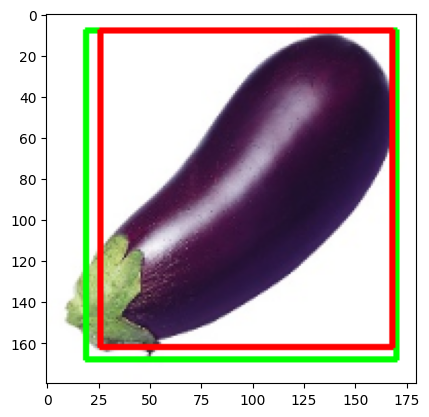

In [18]:
model.load_state_dict(torch.load("best_model.pt"))#load our best weights
model.eval()
with torch.no_grad():
  image, true_bboxes = validset[17]
  image = image.unsqueeze(0)#use unsqueeze(0) because at point validset[1] our image shape is (channel, height, width) so here we're adding batch_size as one at the zeroth axis using unsqueeze and passing the axis #
  #When passing in the image into our model our image tensil should be of (batch_size, channel, height, width) convention
  out_bbox = model(image)#get the predicted bounding box

  utils.compare_plots(image, true_bboxes, out_bbox)#displays the predicted bounding box in red and true bounding box in green
#green bounding box is the true bounding box
#red bounding box is the predicted bounding box